## Prerequisites

Load libraries.

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import wilcoxon
from scipy.stats import norm
mpl.rcParams['axes.unicode_minus'] = True

Define a custom Bland Altman plot.

In [13]:
def bland_altman_plot(m1, m2, sd_limit=1.96, ax=None, annotate=True, 
                        scatter_kwds=None, mean_line_kwds=None, limit_lines_kwds=None):
    """
    Construct a Tukey/Bland-Altman Mean Difference Plot.

    Tukey's Mean Difference Plot (also known as a Bland-Altman plot) is a
    graphical method to analyze the differences between two methods of
    measurement. The mean of the measures is plotted against their difference.

    For more information see
    https://en.wikipedia.org/wiki/Bland-Altman_plot

    Parameters
    ----------
    m1 : array_like
        A 1-d array.
    m2 : array_like
        A 1-d array.
    sd_limit : float
        The limit of agreements expressed in terms of the standard deviation of
        the differences. If `md` is the mean of the differences, and `sd` is
        the standard deviation of those differences, then the limits of
        agreement that will be plotted are md +/- sd_limit * sd.
        The default of 1.96 will produce 95% confidence intervals for the means
        of the differences. If sd_limit = 0, no limits will be plotted, and
        the ylimit of the plot defaults to 3 standard deviations on either
        side of the mean.
    ax : AxesSubplot
        If `ax` is None, then a figure is created. If an axis instance is
        given, the mean difference plot is drawn on the axis.
    scatter_kwds : dict
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.scatter plotting method
    mean_line_kwds : dict
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.axhline plotting method
    limit_lines_kwds : dict
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.axhline plotting method

    Returns
    -------
    Figure
        If `ax` is None, the created figure.  Otherwise the figure to which
        `ax` is connected.

    References
    ----------
    Bland JM, Altman DG (1986). "Statistical methods for assessing agreement
    between two methods of clinical measurement"

    Examples
    --------

    Load relevant libraries.

    >>> import statsmodels.api as sm
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt

    Making a mean difference plot.

    >>> # Seed the random number generator.
    >>> # This ensures that the results below are reproducible.
    >>> np.random.seed(9999)
    >>> m1 = np.random.random(20)
    >>> m2 = np.random.random(20)
    >>> f, ax = plt.subplots(1, figsize = (8,5))
    >>> sm.graphics.mean_diff_plot(m1, m2, ax = ax)
    >>> plt.show()

    .. plot:: plots/graphics-mean_diff_plot.py
    """
    if ax is None:
        try:
            import matplotlib.pyplot as plt
        except:
            raise ImportError("Matplotlib is not found.")
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        fig = ax.figure

    if len(m1) != len(m2):
        raise ValueError('m1 does not have the same length as m2.')
    if sd_limit < 0:
        raise ValueError('sd_limit ({}) is less than 0.'.format(sd_limit))

    means = np.mean([m1, m2], axis=0)
    diffs = m1 - m2
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs, axis=0)

    scatter_kwds = scatter_kwds or {}
    if 's' not in scatter_kwds:
        scatter_kwds['s'] = 20
    mean_line_kwds = mean_line_kwds or {}
    limit_lines_kwds = limit_lines_kwds or {}
    for kwds in [mean_line_kwds, limit_lines_kwds]:
        if 'color' not in kwds:
            kwds['color'] = 'gray'
        if 'linewidth' not in kwds:
            kwds['linewidth'] = 1
    if 'linestyle' not in mean_line_kwds:
        kwds['linestyle'] = '--'
    if 'linestyle' not in limit_lines_kwds:
        kwds['linestyle'] = ':'

    ax.scatter(means, diffs, **scatter_kwds) # Plot the means against the diffs.
    ax.axhline(mean_diff, **mean_line_kwds)  # draw mean line.

    # Annotate mean line with mean difference.
    if annotate:
        ax.annotate('mean diff:\n{}'.format(np.round(mean_diff, 2)),
                    xy=(0.99, 0.5),
                    horizontalalignment='right',
                    verticalalignment='center',
                    fontsize=14,
                    xycoords='axes fraction')

    if sd_limit > 0:
        half_ylim = (1.5 * sd_limit) * std_diff
        ax.set_ylim(mean_diff - half_ylim,
                    mean_diff + half_ylim)
        limit_of_agreement = sd_limit * std_diff
        lower = mean_diff - limit_of_agreement
        upper = mean_diff + limit_of_agreement
        for j, lim in enumerate([lower, upper]):
            ax.axhline(lim, **limit_lines_kwds)
        if annotate:
            range_lim = (0.20 - (-0.20))
            low_lim = (lower - (-0.20))/(0.20 - (-0.20))
            high_lim = (upper - (-0.20))/(0.20 - (-0.20))
            ax.annotate(f'\N{MINUS SIGN}{sd_limit} SD: {lower:0.2g}',
                        xy=(0.99, low_lim-0.02*range_lim), # (0.99, 0.07),
                        horizontalalignment='right',
                        verticalalignment='top',
                        fontsize=14,
                        xycoords='axes fraction')
            ax.annotate(f'+{sd_limit} SD: {upper:0.2g}',
                        xy=(0.99, high_lim+0.02*range_lim), # (0.99, 0.92),
                        horizontalalignment='right',
                        verticalalignment='bottom',
                        fontsize=14,
                        xycoords='axes fraction')
    elif sd_limit == 0:
        half_ylim = 3 * std_diff
        ax.set_ylim(mean_diff - half_ylim,
                    mean_diff + half_ylim)

    ax.set_ylabel('Difference', fontsize=15)
    ax.set_xlabel('Means', fontsize=15)
    ax.tick_params(labelsize=13)
    fig.tight_layout()
    return fig

Set root directory and filename.

In [5]:
ROOT_DIR = ".."
FILENAME = "gait_events_v3.tsv"

Load results data into pandas DataFrame.

In [6]:
df = pd.read_csv(os.path.join(ROOT_DIR, FILENAME), header=0, sep="\t")
df.tail()

,Unnamed: 0,sub_id,filename_prefix,tracked_point,event_type,ix_ref,ix_pred
6030,6030,pp033,sub-pp033_task-walkSlow,right_shank,FC,440.0,440.0
6031,6031,pp033,sub-pp033_task-walkSlow,right_shank,FC,768.0,768.0
6032,6032,pp033,sub-pp033_task-walkSlow,right_shank,FC,1113.0,1112.0
6033,6033,pp033,sub-pp033_task-walkSlow,right_shank,FC,1450.0,1451.0
6034,6034,pp033,sub-pp033_task-walkSlow,right_shank,FC,1804.0,1804.0


In [7]:
# Split ICs and FCs
df_ic = df.loc[df["event_type"]=="IC"]
df_ic_clean = df_ic[(df_ic["ix_ref"].notna()) & (df_ic["ix_pred"].notna())]
df_fc = df.loc[df["event_type"]=="FC"]
df_fc_clean = df_fc[(df_fc["ix_ref"].notna()) & (df_fc["ix_pred"].notna())]

In [8]:
df_ic_clean.head()

,Unnamed: 0,sub_id,filename_prefix,tracked_point,event_type,ix_ref,ix_pred
0,0,pp156,sub-pp156_task-walkFast,left_ankle,IC,139.0,139.0
1,1,pp156,sub-pp156_task-walkFast,left_ankle,IC,329.0,325.0
2,2,pp156,sub-pp156_task-walkFast,left_ankle,IC,514.0,513.0
3,3,pp156,sub-pp156_task-walkFast,left_ankle,IC,700.0,691.0
4,4,pp156,sub-pp156_task-walkFast,left_ankle,IC,882.0,877.0


In [9]:
df_ic_clean["diff_msec"] = (df_ic_clean["ix_ref"] - df_ic_clean["ix_pred"]) * 5
df_fc_clean["diff_msec"] = (df_fc_clean["ix_ref"] - df_fc_clean["ix_pred"]) * 5

/tmp/ipykernel_88799/3878284963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ic_clean["diff_msec"] = (df_ic_clean["ix_ref"] - df_ic_clean["ix_pred"]) * 5
/tmp/ipykernel_88799/3878284963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fc_clean["diff_msec"] = (df_fc_clean["ix_ref"] - df_fc_clean["ix_pred"]) * 5


## Time Agreement
Qualitatively assess the time error by using box plots.

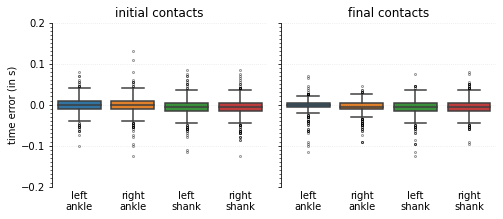

In [12]:
my_tracked_points = ["left_ankle", "right_ankle", "left_shank", "right_shank"]
cm = 1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(18*cm, 8*cm), sharey=True)
sns.boxplot(ax=axs[0], data=df_ic_clean, y="diff_msec", x="tracked_point", order=my_tracked_points, showfliers=True, flierprops=dict(marker='o', ms=2, mec=(0, 0, 0), alpha=0.4, mfc='none'))
sns.despine(bottom=True)
axs[0].set_xlabel("")  # clear xlabel
axs[0].set_xticklabels([s.replace("_", "\n") for s in my_tracked_points])
axs[0].set_ylabel('time error (in s)')  # set ylabel
axs[0].set_yticks(np.arange(-200, 250, 100))
# axs[0].set_yticklabels(np.arange(-200, 250, 100)/1000)
axs[0].set_yticklabels([f'{x}'.replace('-', '\N{MINUS SIGN}') for x in np.arange(-200, 250, 100)/1000])
axs[0].yaxis.set_minor_locator(plt.MultipleLocator(10))
axs[0].grid(visible=True, which="major", axis="y", c=(0, 0, 0), alpha=0.1, ls=":")
axs[0].set_title("initial contacts")
axs[0].tick_params(axis="x", which="both", length=0)
sns.boxplot(ax=axs[1], data=df_fc_clean, y="diff_msec", x="tracked_point", order=my_tracked_points, showfliers=True, flierprops=dict(marker='o', ms=2, mec=(0, 0, 0), alpha=0.4, mfc='none'))
sns.despine(bottom=True)
axs[1].set_xlabel("")  # clear xlabel
axs[1].set_ylabel("")
axs[1].set_xticklabels([s.replace("_", "\n") for s in my_tracked_points])
# axs[1].set_ylabel('time error / ms')  # set ylabel
axs[1].set_yticks(np.arange(-200, 250, 100))
axs[1].yaxis.set_minor_locator(plt.MultipleLocator(10))
axs[1].grid(visible=True, which="major", axis="y", c=(0, 0, 0), alpha=0.1, ls=":")
axs[1].set_title("final contacts")
axs[1].tick_params(axis="x", which="both", length=0)
plt.tight_layout()
plt.savefig("/home/robbin/Desktop/box_plots_tracked_points_with_outliers.pdf", dpi=300)
# plt.savefig("D:\\Projects\\my-gait-events-tcn\\paper\\MDPI_template\\fig\\box_plots_tracked_points_with_outliers.pdf", dpi=300)
plt.show()

## Derive Stride-Specific Gait Parameters

In [42]:
df_gait_metrics = {"sub_id": [],
                   "gender": [],
                   "age": [],
                   "participant_type": [],
                   "task": [],
                   "run": [],
                   "tracked_point": [],
                   "ix_ref": [],
                   "ix_pred": [],
                   "stride_time_ref": [],
                   "stride_time_pred": [],
                   "stance_time_ref": [],
                   "stance_time_pred": [],
                   "swing_time_ref": [],
                   "swing_time_pred": []}

for sub_id in df["sub_id"].unique():
    # print(f"{sub_id}")
    df_sel = df.loc[df["sub_id"]==sub_id]
    for task in df_sel["task"].unique():
        # print(f"    {task:s}")
        df_sel = df.loc[(df["sub_id"]==sub_id) & (df["task"]==task)]
        for run in df_sel["run"].unique():
            if not isinstance(run, str):
                for tracked_point in df_sel["tracked_point"].unique():
                    # print(f"        {tracked_point}")
                    df_sel = df.loc[(df["sub_id"]==sub_id) & (df["task"]==task) & (df["run"].isna()) & (df["tracked_point"]==tracked_point)]
                    gender = df_sel["gender"].iloc[0]
                    age = df_sel["age"].iloc[0]
                    participant_type = df_sel["participant_type"].iloc[0]
                    if not(df_sel[["ix_ref", "ix_pred"]].isna().any().any()):
                        ix_IC_ref = np.sort(df_sel.loc[df_sel["event_type"]=="IC"]["ix_ref"].values[:])
                        ix_IC_pred = np.sort(df_sel.loc[df_sel["event_type"]=="IC"]["ix_pred"].values[:])
                        ix_FC_ref = np.sort(df_sel.loc[df_sel["event_type"]=="FC"]["ix_ref"].values[:])
                        ix_FC_pred = np.sort(df_sel.loc[df_sel["event_type"]=="FC"]["ix_pred"].values[:])
                        if len(ix_IC_ref)==0 or len(ix_IC_pred)==0 or len(ix_FC_ref)==0 or len(ix_FC_pred)==0:
                            continue
                        for i in range(len(ix_IC_ref)-1):
                            stride_time_ref = ( ix_IC_ref[i+1] - ix_IC_ref[i] ) / 200
                            stride_time_pred = ( ix_IC_pred[i+1] - ix_IC_pred[i] ) / 200
                            f = np.argwhere(ix_FC_ref > ix_IC_ref[i])[:,0][0]
                            stance_time_ref = ( ix_FC_ref[f] - ix_IC_ref[i] ) / 200
                            stance_time_pred = ( ix_FC_pred[f] - ix_IC_pred[i] ) / 200
                            swing_time_ref = ( ix_IC_ref[i+1] - ix_FC_ref[f] ) / 200
                            swing_time_pred = ( ix_IC_pred[i+1] - ix_FC_pred[f] ) / 200
                            
                            # Add to dict
                            df_gait_metrics["sub_id"].append(sub_id)
                            df_gait_metrics["gender"].append(gender)
                            df_gait_metrics["age"].append(age)
                            df_gait_metrics["participant_type"].append(participant_type)
                            df_gait_metrics["task"].append(task)
                            df_gait_metrics["run"].append("")
                            df_gait_metrics["tracked_point"].append(tracked_point)
                            df_gait_metrics["ix_ref"].append(ix_IC_ref[i])
                            df_gait_metrics["ix_pred"].append(ix_IC_pred[i])
                            df_gait_metrics["stride_time_ref"].append(stride_time_ref)
                            df_gait_metrics["stride_time_pred"].append(stride_time_pred)
                            df_gait_metrics["stance_time_ref"].append(stance_time_ref)
                            df_gait_metrics["stance_time_pred"].append(stance_time_pred)
                            df_gait_metrics["swing_time_ref"].append(swing_time_ref)
                            df_gait_metrics["swing_time_pred"].append(swing_time_pred)
            else:
                df_sel = df.loc[(df["sub_id"]==sub_id) & (df["task"]==task) & (df["run"]==run)]
                for tracked_point in df_sel["tracked_point"].unique():
                    # print(f"        {tracked_point}")
                    df_sel = df.loc[(df["sub_id"]==sub_id) & (df["task"]==task) & (df["run"]==run) & (df["tracked_point"]==tracked_point)]
                    gender = df_sel["gender"].iloc[0]
                    age = df_sel["age"].iloc[0]
                    participant_type = df_sel["participant_type"].iloc[0]
                    if not(df_sel[["ix_ref", "ix_pred"]].isna().any().any()):
                        ix_IC_ref = np.sort(df_sel.loc[df_sel["event_type"]=="IC"]["ix_ref"].values[:])
                        ix_IC_pred = np.sort(df_sel.loc[df_sel["event_type"]=="IC"]["ix_pred"].values[:])
                        ix_FC_ref = np.sort(df_sel.loc[df_sel["event_type"]=="FC"]["ix_ref"].values[:])
                        ix_FC_pred = np.sort(df_sel.loc[df_sel["event_type"]=="FC"]["ix_pred"].values[:])
                        if len(ix_IC_ref)==0 or len(ix_IC_pred)==0 or len(ix_FC_ref)==0 or len(ix_FC_pred)==0:
                            continue
                        for i in range(len(ix_IC_ref)-1):
                            stride_time_ref = ( ix_IC_ref[i+1] - ix_IC_ref[i] ) / 200
                            stride_time_pred = ( ix_IC_pred[i+1] - ix_IC_pred[i] ) / 200
                            f = np.argwhere(ix_FC_ref > ix_IC_ref[i])[:,0][0]
                            stance_time_ref = ( ix_FC_ref[f] - ix_IC_ref[i] ) / 200
                            stance_time_pred = ( ix_FC_pred[f] - ix_IC_pred[i] ) / 200
                            swing_time_ref = ( ix_IC_ref[i+1] - ix_FC_ref[f] ) / 200
                            swing_time_pred = ( ix_IC_pred[i+1] - ix_FC_pred[f] ) / 200
                            
                            # Add to dict
                            df_gait_metrics["sub_id"].append(sub_id)
                            df_gait_metrics["gender"].append(gender)
                            df_gait_metrics["age"].append(age)
                            df_gait_metrics["participant_type"].append(participant_type)
                            df_gait_metrics["task"].append(task)
                            df_gait_metrics["run"].append(run)
                            df_gait_metrics["tracked_point"].append(tracked_point)
                            df_gait_metrics["ix_ref"].append(ix_IC_ref[i])
                            df_gait_metrics["ix_pred"].append(ix_IC_pred[i])
                            df_gait_metrics["stride_time_ref"].append(stride_time_ref)
                            df_gait_metrics["stride_time_pred"].append(stride_time_pred)
                            df_gait_metrics["stance_time_ref"].append(stance_time_ref)
                            df_gait_metrics["stance_time_pred"].append(stance_time_pred)
                            df_gait_metrics["swing_time_ref"].append(swing_time_ref)
                            df_gait_metrics["swing_time_pred"].append(swing_time_pred) 
                    

KeyError: 'task'

In [ ]:
df_gait_metrics = pd.DataFrame(df_gait_metrics)

In [ ]:
# df_gait_metrics.to_csv(os.path.join(ROOT_DIR, "gait_metrics_v3.tsv"), sep="\t")

In [3]:
df_gait_metrics = pd.read_csv("../gait_metrics_v3.tsv", sep="\t")
df_gait_metrics.head()

,Unnamed: 0,sub_id,gender,age,participant_type,task,run,tracked_point,ix_ref,ix_pred,stride_time_ref,stride_time_pred,stance_time_ref,stance_time_pred,swing_time_ref,swing_time_pred
0,0,pp061,M,24,YA,Slow,NaN,right_ankle,174.0,179.0,1.550,1.520,0.980,1.005,0.570,0.515
1,1,pp061,M,24,YA,Slow,NaN,right_ankle,484.0,483.0,1.495,1.500,0.975,0.990,0.520,0.510
2,2,pp061,M,24,YA,Slow,NaN,right_ankle,783.0,783.0,1.515,1.515,0.995,1.010,0.520,0.505
3,3,pp061,M,24,YA,Slow,NaN,right_ankle,1086.0,1086.0,1.650,1.635,1.045,1.030,0.605,0.605
4,4,pp061,M,24,YA,Slow,NaN,left_shank,12.0,12.0,1.600,1.585,1.055,1.060,0.545,0.525


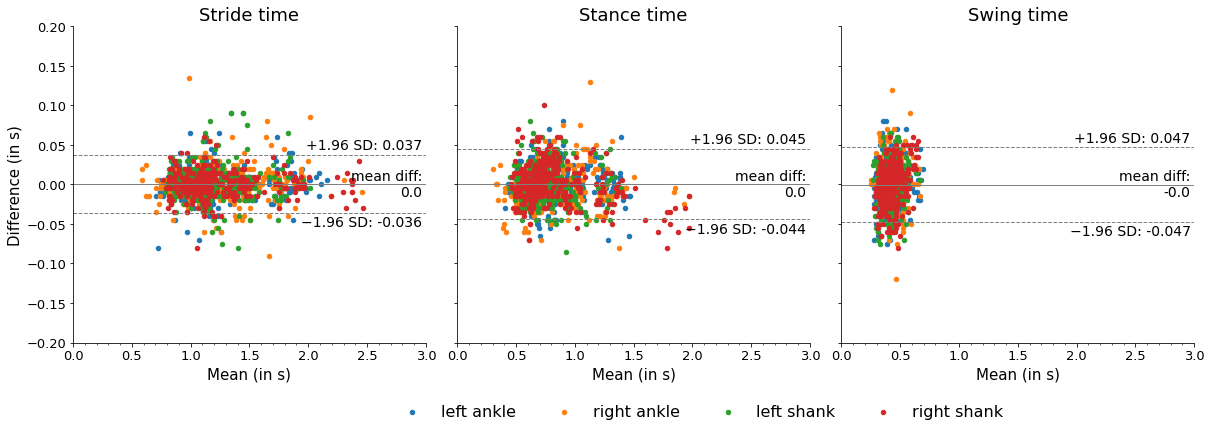

In [15]:
cm = 1 / 2.54
fig, axs = plt.subplots(1, 3, figsize=(43*cm, 14*cm), sharey=True)
bland_altman_plot(df_gait_metrics.stride_time_ref, df_gait_metrics.stride_time_pred, ax=axs[0], annotate=True, scatter_kwds=dict(c="w", alpha=0.01))
bland_altman_plot(df_gait_metrics.stance_time_ref, df_gait_metrics.stance_time_pred, ax=axs[1], annotate=True, scatter_kwds=dict(c="w", alpha=0.01))
bland_altman_plot(df_gait_metrics.swing_time_ref, df_gait_metrics.swing_time_pred, ax=axs[2], annotate=True, scatter_kwds=dict(c="w", alpha=0.01))
for tracked_point in ["left_ankle", "right_ankle", "left_shank", "right_shank"]:
    df_sel = df_gait_metrics.loc[df_gait_metrics["tracked_point"]==tracked_point]
    bland_altman_plot(df_sel.stride_time_ref, df_sel.stride_time_pred, ax=axs[0], annotate=False, mean_line_kwds=dict(ls="none"), limit_lines_kwds=dict(ls="none"))
    bland_altman_plot(df_sel.stance_time_ref, df_sel.stance_time_pred, ax=axs[1], annotate=False, mean_line_kwds=dict(ls="none"), limit_lines_kwds=dict(ls="none"))
    bland_altman_plot(df_sel.swing_time_ref, df_sel.swing_time_pred, ax=axs[2], annotate=False, scatter_kwds=dict(label=tracked_point.replace("_", " ")), mean_line_kwds=dict(ls="none"), limit_lines_kwds=dict(ls="none"))
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].set_title("Stride time", size=18)
axs[0].set_xlabel("Mean (in s)")
axs[0].set_ylabel("Difference (in s)")
axs[0].set_xticks(np.arange(0, 3.5, 0.5))
axs[0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].set_title("Stance time", size=18)
axs[1].set_xlabel("Mean (in s)")
axs[1].set_ylabel("")
axs[1].set_xticks(np.arange(0, 3.5, 0.5))
axs[1].xaxis.set_minor_locator(plt.MultipleLocator(0.1))
axs[2].spines["top"].set_visible(False)
axs[2].spines["right"].set_visible(False)
axs[2].set_title("Swing time", size=18)
axs[2].set_xlabel("Mean (in s)")
axs[2].set_ylabel("")
axs[2].set_xticks(np.arange(0, 3.5, 0.5))
axs[2].xaxis.set_minor_locator(plt.MultipleLocator(0.1))
axs[0].set_ylim((-0.20, 0.20))
plt.tight_layout()
plt.legend(bbox_to_anchor=(0.5, -0.15), ncol=4, frameon=False, fontsize=16)
plt.savefig("/home/robbin/Desktop/bland_altman_plots_stride_params.pdf", dpi=300, bbox_inches="tight")
# plt.savefig("D:\\Projects\\my-gait-events-tcn\\paper\\MDPI_template\\fig\\bland_altman_plots_stride_params.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
alpha = 0.05

for tracked_point in ["left_ankle", "right_ankle", "left_shank", "right_shank"]:
    df_sel = df_gait_metrics.loc[df_gait_metrics["tracked_point"]==tracked_point]
    
    # Stride time
    m1 = df_sel.stride_time_ref
    m2 = df_sel.stride_time_pred
    means = np.mean([m1, m2], axis=0)
    diffs = m1 - m2
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs, axis=0)
    limit_of_agreement = norm.ppf(1-(alpha/2)) * std_diff
    lower_lim = mean_diff - limit_of_agreement
    upper_lim = mean_diff + limit_of_agreement
    statistic, pvalue = wilcoxon(m1, m2, alternative="two-sided")
    print(f"{tracked_point.replace('_', ' '):>12s}{'stride time':>12s}{mean_diff:>8.3f}{lower_lim:>8.3f}{upper_lim:>8.3f}{pvalue:>8.3f} {statistic:>1.3f}")
    
    # Stance time
    m1 = df_sel.stance_time_ref
    m2 = df_sel.stance_time_pred
    means = np.mean([m1, m2], axis=0)
    diffs = m1 - m2
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs, axis=0)
    limit_of_agreement = norm.ppf(1-(alpha/2)) * std_diff
    lower_lim = mean_diff - limit_of_agreement
    upper_lim = mean_diff + limit_of_agreement
    statistic, pvalue = wilcoxon(m1, m2, alternative="two-sided")
    print(f"{12*' ':>12s}{'stance time':>12s}{mean_diff:>8.3f}{lower_lim:>8.3f}{upper_lim:>8.3f}{pvalue:>8.3f} {statistic:>1.3f}")
    
    # Swing time
    m1 = df_sel.swing_time_ref
    m2 = df_sel.swing_time_pred
    means = np.mean([m1, m2], axis=0)
    diffs = m1 - m2
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs, axis=0)
    limit_of_agreement = norm.ppf(1-(alpha/2)) * std_diff
    lower_lim = mean_diff - limit_of_agreement
    upper_lim = mean_diff + limit_of_agreement
    statistic, pvalue = wilcoxon(m1, m2, alternative="two-sided")
    print(f"{12*' ':>12s}{'swing time':>12s}{mean_diff:>8.3f}{lower_lim:>8.3f}{upper_lim:>8.3f}{pvalue:>8.3f} {statistic:>1.3f}")

  left ankle stride time   0.001  -0.035   0.036   0.671 24977.500
             stance time   0.002  -0.039   0.042   0.073 27330.000
              swing time  -0.001  -0.045   0.043   0.248 27378.500
 right ankle stride time   0.000  -0.039   0.040   0.856 22006.000
             stance time  -0.002  -0.048   0.044   0.033 21010.500
              swing time   0.003  -0.046   0.051   0.021 21287.000
  left shank stride time   0.001  -0.039   0.041   0.445 18771.000
             stance time   0.002  -0.043   0.046   0.339 19321.000
              swing time  -0.001  -0.049   0.047   0.885 21472.500
 right shank stride time  -0.000  -0.031   0.031   0.696 18326.000
             stance time   0.002  -0.046   0.049   0.237 22239.000
              swing time  -0.002  -0.049   0.046   0.174 21381.000
